# Editing analysis - Quick Start

#### Billy Li et al. Nature Methods 2012.
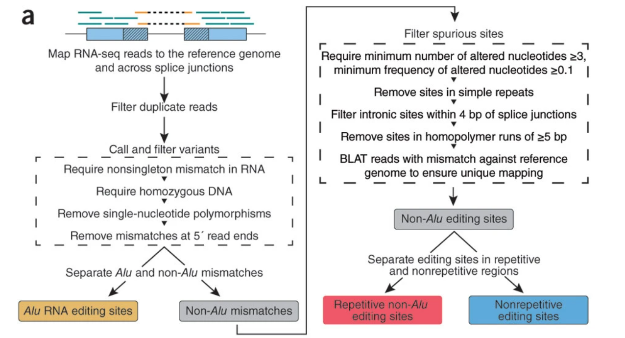

## #Denovo Call Editing - Prepare

### Imports

In [ ]:
import pandas as pd
import subprocess
import os
import glob
import random
import pybedtools
import pysam
import numpy as np
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor as Pool
from tqdm import tqdm
from math import ceil
import matplotlib.pyplot as plt

### Data
##### 1. ADAR_KO  1sample  paired-end HEK293 RNA （SRR11304481）  call editing sites
##### 2. ADAR_WT  1sample  paired-end HEK293 RNA （SRR11304482） call edting sites
##### 3. WGS      1sample  paired-end HEK293 DNA （SRR2123657）  identify homozygous DNA sites

In [ ]:
# Directories
BAM_DIR = './data/1_bam'
dePCRduplicates_BAM_DIR = './data/2_dedup_bam'
PILEUP_RAW_DIR = './data/3_pileup_raw'
EDITING_DIR = './data/4_editing'

# File paths
REF_fa = './data/reference/hg38.fa'   # downloaded by yourself from gencode if there is not provided
GTF = './data/reference/hg38.gtf'     # downloaded by yourself from gencode if there is not provided

interested_genes = './data/interested_genes.txt'

### Analysis before BAM - preprocessed the raw FASTQ files in advance
#### Step-1-trim - removed six bases to reduce the effect of random hexamer priming
            cutadapt -q 20,20 --trim-n -m 15 -a AGATCGGAAGAGCACACGTCTGAACTCCAGTCA -A AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGT -u 6 -U 6
#### Step-2-alignment
##### WGS -
            bwa mem -t 20 -M hg38.fa WGS_1.trim.fastq.gz WGS_2.trim.fastq.gz | samtools view -bS | samtools sort
##### RNAseq -
            hisat2
#### Step-3-get intersting genes from bam
            extracted reads from BAM files that map to around fifty gene regions

In [ ]:
# print bam files
for bam in glob.glob(os.path.join(BAM_DIR, '*.bam')):
    print(bam)

./data/1_bam/WGS.bam
./data/1_bam/ADAR_WT.bam
./data/1_bam/ADAR_KO.bam


## #Denovo Call Editing - Start

### Step 1: Remove PCR duplicates from bams
        to remove duplicate reads generated during PCR amplification
#### Used tools
        Picard

In [ ]:
# dePCR duplicates
for raw_bam in glob.glob(os.path.join(BAM_DIR, '*.bam')):
    sample_name = os.path.basename(raw_bam).split('.bam')[0]
    out_bam = os.path.join(dePCRduplicates_BAM_DIR, f'{sample_name}_dePCRdup.bam')
    subprocess.run(f'java -jar /public/home/lix/lix/apps/picard.jar MarkDuplicates I={raw_bam} O={out_bam} M={os.path.join(dePCRduplicates_BAM_DIR, sample_name + "_dup_metrics.txt")} REMOVE_DUPLICATES=true VALIDATION_STRINGENCY=LENIENT TMP_DIR={dePCRduplicates_BAM_DIR}/tmp', shell=True)
    subprocess.run(f'/public/apps/bin/samtools index {out_bam}', shell=True)

INFO	2025-12-29 10:57:02	MarkDuplicates	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** 
https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    MarkDuplicates -I ./data/1_bam/WGS.bam -O ./data/2_dedup_bam/WGS_dePCRdup.bam -M ./data/2_dedup_bam/WGS_dup_metrics.txt -REMOVE_DUPLICATES true -VALIDATION_STRINGENCY LENIENT -TMP_DIR ./data/2_dedup_bam/tmp
**********


10:57:02.398 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/public/data/lix/apps/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Mon Dec 29 10:57:02 CST 2025] MarkDuplicates INPUT=[./data/1_bam/WGS.bam] OUTPUT=./data/2_dedup_bam/WGS_dePCRdup.bam METRICS_FILE=./data/2_dedup_bam/WGS_dup_metrics.txt REMOVE_DUPLICATES=true TMP_DIR=[./data/2_dedup_bam/tmp] VALIDATION_STRINGENC

### Step 2: Call variants
#### Conditions:
        Base quality >= 20
        Mapping quality >= 20
#### Used tools：
        Samtools mplieup - to collect base information at each genomic position

In [ ]:
# print dePCR duplicates removed bam files
for dedup_bam in glob.glob(os.path.join(dePCRduplicates_BAM_DIR, '*_dePCRdup.bam')):
    print(dedup_bam)

./data/2_dedup_bam/WGS_dePCRdup.bam
./data/2_dedup_bam/ADAR_KO_dePCRdup.bam
./data/2_dedup_bam/ADAR_WT_dePCRdup.bam


In [ ]:
# 1 - mpileup for all genes
PILEUP_RAW_DIR = './data/3_pileup_raw'

for bam in glob.glob(os.path.join(dePCRduplicates_BAM_DIR, '*_dePCRdup.bam')):
    sample_name = os.path.basename(bam).split('_dePCRdup.bam')[0]
    out_pileup = os.path.join(PILEUP_RAW_DIR, f'{sample_name}_pileup.txt')
    subprocess.run(f'/public/apps/bin/samtools mpileup -A -B -f {REF_fa} -d 100000 -Q 20 -q 20 {bam} > {out_pileup}', shell=True)

[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files


In [ ]:
# 2 - display pileup df results (example for ADAR_KO)
ADAR_KO_pileup = os.path.join(PILEUP_RAW_DIR, 'ADAR_KO_pileup.txt')
pileup_df = pd.read_csv(ADAR_KO_pileup, sep='\t', header=None,
                         names=['chrom', 'pos', 'ref_base', 'coverage', 'bases', 'base_qualities'])

print("ADAR_KO mpileup results:")
display(pileup_df)

# filter A-to-G / T-to-C editing sites (example, not the final results)
filtered_df = pileup_df[
    ((pileup_df['ref_base'] == 'A') & (pileup_df['bases'].str.contains('G'))) |
    ((pileup_df['ref_base'] == 'T') & (pileup_df['bases'].str.contains('C')))
]
print("Filtered A-to-G editing sites:")
display(filtered_df)

# parse mpileup results
# 1. match
##   .	Base matches the reference on the forward strand
##   ,	Base matches the reference on the reverse strand
# 2. mismatch
##   A C G T	Mismatch on the forward strand
##   a c g t	Mismatch on the reverse strand
# 3. indels
##  +[length][sequence] example: +2AG
##  -[length][sequence] example: -2AG
# 4. Start and end of bases
##  ^	Start of a read segment
##  $	End of a read
# 5. deletion
##  *	Placeholder for a deletion
# 6. Reference skips (spliced alignments)
##  >	Reference skip on the forward strand
##  <	Reference skip on the reverse strand

ADAR_KO mpileup results:


,chrom,pos,ref_base,coverage,bases,base_qualities
0,chr1,16950361,C,2,^].^].,JJ
1,chr1,16950362,C,2,..,JJ
2,chr1,16950363,T,2,..,JJ
3,chr1,16950364,A,2,..,JJ
4,chr1,16950365,T,2,..,AA
...,...,...,...,...,...,...
4020032,chrX,154400576,G,1,",",A
4020033,chrX,154400577,T,1,",",J
4020034,chrX,154400578,G,1,",",J
4020035,chrX,154400579,A,1,",",J


Filtered A-to-G editing sites:


,chrom,pos,ref_base,coverage,bases,base_qualities
24924,chr1,16975285,A,123,>>GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,FFJJJJJJJJJJJJJJJJJJFJJJJJJJJJJJJJJJJJJJJJJJJJ...
25611,chr1,16975972,A,190,>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>...,FFJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJAAJJJJJJJJJJJJ...
26750,chr1,16977111,A,158,>>....<<......................>>.................,FFJJFFJJAAFFJJJJFFFFAAJJJJ77JJFFJJJJ<<FFJJFFJJ...
101890,chr1,92841775,T,267,">><<>>,$,$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...",JJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJ...
159272,chr1,115831686,A,2,.-1G.-1G,JJ
...,...,...,...,...,...,...
3990433,chrX,154370977,T,211,<.$.$............................................,FAAJJJJFFJJ<<JJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJ...
3990457,chrX,154371001,T,228,<................................................,FJJJJFFJJJJJJJJJJJJJJFFJJJJ<<JJJJJJJJJJJJJJJJJ...
3990461,chrX,154371005,A,228,<.$.$............................................,FJJJJJJJJJJJJFFJJJJFFJJJJJJFFJJJJFFJJJJJJJJJJJ...
3990605,chrX,154371149,T,145,<.$.$................................CC..........,FJJJJJJJJJJJJJJFFJJJJJJJJJJJJJJJJJJJJ<<JJJJJJJ...


### Step 3: filter candidates

#### Filters-1 -> get 'Alu RNA editing sites' and 'non-Alu mismatches':
        1) require nonsingleton mismatch in RNA
        Base quality >= 20
        Mapping quelity >= 20
        min_coverage >= 2
        min_variant_ratio >= 0.02
        min_variant_count >= 2
        2)
        Require homozygous DNA（min_cov=10, min_major_frac=0.95, max_minor_count=2, base_quality >= 20）
        3)
        Remove SNP
        4)
        Remove mismatches at 5' read ends(have done it in "cutadapt -u 6 -U 6")
#### Data
        1) pileup results:
                        1 - raw RNAseq 'samtools mpileup' results data
                        2 - raw WGS 'samtools mpileup' results data -> to get homozygous DNA sites
        2) required filter files:
                        1 - Alu region data
                        2 - SNP region data（data from 1000Genomes）
##### Used tools：
        bedtools


#### 1 - prepare the homozygous DNA data and SNP data
        A site was called homozygous if 10 or more reads contained the same base that represented more than 95% of
        the complete coverage and if only 2 or fewer alternative bases were present at the same position.

        more than 10 reads, the major base to make up over 95% of the coverage, and at most two reads supporting minor bases.

In [ ]:
def get_homozygous_sites_from_WGSpileup_df(WGS_raw_pileup_df,min_coverage=10,min_majorBase_fraction=0.95,max_minorBase_count=2):

    def parse_WGSpileup_bases_df(WGS_raw_pileup_df, min_base_qual=20):
        df = WGS_raw_pileup_df.copy()
        df["A"] = 0
        df["T"] = 0
        df["C"] = 0
        df["G"] = 0
        df["ref_count"] = 0

        for idx, row in df.iterrows():
            bases = row["bases"]
            quals = row["quals"]

            i = 0
            q = 0
            n = len(bases)

            while i < n:
                b = bases[i]

                # read start (^ + MAPQ)
                if b == "^":
                    i += 2
                    continue

                # read end
                if b == "$":
                    i += 1
                    continue

                # indel
                if b in "+-":
                    i += 1
                    num = ""
                    while i < n and bases[i].isdigit():
                        num += bases[i]
                        i += 1
                    i += int(num)
                    continue

                # base quality
                if q >= len(quals):
                    break

                base_qual = ord(quals[q]) - 33
                q += 1

                if base_qual < min_base_qual:
                    i += 1
                    continue

                if b in ".,":                 # reference
                    df.at[idx, "ref_count"] += 1
                elif b.upper() in ["A", "T", "C", "G"]:
                    df.at[idx, b.upper()] += 1

                i += 1

        return df

    pileup_df = parse_WGSpileup_bases_df(WGS_raw_pileup_df)

    homo_sites = []
    for _, row in pileup_df.iterrows():
        A, T, C, G = row["A"], row["T"], row["C"], row["G"]
        ref = row["ref"].upper()
        ref_count = row["ref_count"]

        coverage = A + T + C + G + ref_count
        if coverage < min_coverage:
            continue

        base_counts = {
            "A": A,
            "T": T,
            "C": C,
            "G": G,
            ref: ref_count
        }

        major_base = max(base_counts, key=base_counts.get)
        major_count = base_counts[major_base]
        minor_count = coverage - major_count

        if (
            major_count / coverage >= min_majorBase_fraction and
            minor_count <= max_minorBase_count
        ):
            homo_sites.append({
                "chr": row["chr"],
                "pos": row["pos"],
                "ref": ref,
                "major_base": major_base,
                "coverage": coverage,
                "major_frac": round(major_count / coverage, 4)
            })

    return pd.DataFrame(homo_sites)



In [ ]:
# invoke 'get_homozygous_sites_from_WGSpileup_df' function on WGS pileup data
WGS_pileup = './data/3_pileup_raw/WGS_pileup.txt'
WGS_pileup_df = pd.read_csv(WGS_pileup, sep='\t', header=None, names=['chr','pos','ref','coverage','bases','quals'])
homozygous_DNA_sites_df = get_homozygous_sites_from_WGSpileup_df(WGS_pileup_df)
homozygous_DNA_sites_df.to_csv(os.path.join(EDITING_DIR, 'homozygous_DNA_sites.txt'), sep='\t', index=False)

print('homozygous DNA sites:')
display(homozygous_DNA_sites_df)

homozygous DNA sites:


,chr,pos,ref,major_base,coverage,major_frac
0,chr1,16975070,G,G,10,1.0
1,chr1,16975071,G,G,10,1.0
2,chr1,16975072,G,G,10,1.0
3,chr1,16975075,C,C,10,1.0
4,chr1,16975076,C,C,10,1.0
...,...,...,...,...,...,...
1777154,chrX,154374502,T,T,12,1.0
1777155,chrX,154374503,C,C,12,1.0
1777156,chrX,154374504,A,A,12,1.0
1777157,chrX,154374505,C,C,12,1.0


In [ ]:
# show the prepared SNP data, Alu region data
SNP_df = pd.read_csv('./data/reference/hg38_SNP.bed', sep = '\t', header = None, names=['chrom', 'start', 'end'])
Alu_df = pd.read_csv('./data/reference/hg38_Alu.bed', sep = '\t', header = None, names=['chrom', 'start', 'end'])

print('SNP sites：')
display(SNP_df)
print('Alu region：')
display(SNP_df)

SNP sites：


,chrom,start,end
0,chr1,10176,10177
1,chr1,10351,10352
2,chr1,10615,10616
3,chr1,11007,11008
4,chr1,11011,11012
...,...,...,...
16046910,chr22_KI270738v1_random,82899,82900
16046911,chr22_KI270738v1_random,82921,82922
16046912,chr22_KI270738v1_random,82929,82930
16046913,chr22_KI270738v1_random,82936,82937


Alu region：


,chrom,start,end
0,chr1,10176,10177
1,chr1,10351,10352
2,chr1,10615,10616
3,chr1,11007,11008
4,chr1,11011,11012
...,...,...,...
16046910,chr22_KI270738v1_random,82899,82900
16046911,chr22_KI270738v1_random,82921,82922
16046912,chr22_KI270738v1_random,82929,82930
16046913,chr22_KI270738v1_random,82936,82937


nonAlu_repeat region：


,chrom,start,end
0,chr1,10176,10177
1,chr1,10351,10352
2,chr1,10615,10616
3,chr1,11007,11008
4,chr1,11011,11012
...,...,...,...
16046910,chr22_KI270738v1_random,82899,82900
16046911,chr22_KI270738v1_random,82921,82922
16046912,chr22_KI270738v1_random,82929,82930
16046913,chr22_KI270738v1_random,82936,82937


#### 2 - Filter:
        1)
        require nonsingleton mismatch in RNA
        2)
        Require homozygous DNA（min_cov=10, min_major_frac=0.95, max_minor_count=2, base_quality >= 20）
        3)
        Remove SNP
        4)
        Remove mismatches at 5' read ends(has done in "cutadapt -u 6 -U 6")

##### 1） require nonsingleton mismatch in RNA
        - base quality >= 20
        - reads coverage >= 2
        - variant count >= 2
        - variant ratio >= 0.02

In [ ]:
def get_nonsingleton_mismatch_df(raw_pileup_df, min_base_quality=20, min_coverage=2, max_coverage=1_000_000,
                                    min_variant_frequency=0.02, min_variant_count=2):
    """
    Parameters
    ----------
    raw_pileup_df : pd.DataFrame
    min_base_quality : int
    min_cov : int
    max_cov : int
    min_var_freq : float
    min_var_count : int

    """
    results = []

    for _, row in raw_pileup_df.iterrows():
        chr_ = row['chr']
        pos = row['pos']
        ref_base = row['ref']
        coverage = row['coverage']
        bases = row['bases']
        quality = row['quality']

        if coverage < min_coverage or coverage > max_coverage:
            continue

        # parse bases and qualities
        pile_bases = list(bases)
        quality_scores = [ord(q)-33 for q in quality]  # Illumina phred+33

        # 初始化计数
        counts = {'A':0,'T':0,'C':0,'G':0,'ref':0}

        i = 0
        read_idx = 0
        while i < len(pile_bases):
            base = pile_bases[i]

            # ignore start and end of read
            if base == '^':  # skip the next character (mapping quality)
                i += 2
                continue
            elif base == '$':
                i += 1
                continue

            # 忽略 indel
            if base in '+-':
                i += 1
                indel_len = ''
                while pile_bases[i].isdigit():
                    indel_len += pile_bases[i]
                    i += 1
                indel_len = int(indel_len)
                i += indel_len
                continue

            # 碱基质量
            if read_idx < len(quality_scores) and quality_scores[read_idx] >= min_base_quality:
                if base in '.,':  # match reference
                    counts['ref'] += 1
                elif base.upper() == 'A':
                    counts['A'] += 1
                elif base.upper() == 'T':
                    counts['T'] += 1
                elif base.upper() == 'C':
                    counts['C'] += 1
                elif base.upper() == 'G':
                    counts['G'] += 1
            read_idx += 1
            i += 1

        total_count = counts['ref'] + counts['A'] + counts['T'] + counts['C'] + counts['G']

        # 筛选可能变异
        for nuc in ['A','T','C','G']:
            alt_count = counts[nuc]
            if alt_count >= min_variant_count and (alt_count / total_count) >= min_variant_frequency:
                var_freq = alt_count / total_count
                results.append([chr_, pos, total_count, ref_base, nuc, round(var_freq,3), alt_count])

    result_df = pd.DataFrame(results, columns=['chr','pos','coverage','ref','alt','var_freq','alt_count'])
    return result_df

In [ ]:
# invoke the function 'get_nonsingleton_mismatch_df' on ADAR_KO and ADAR_WT pileup data to get editing sites
ADAR_KO_pileup = os.path.join(PILEUP_RAW_DIR, 'ADAR_KO_pileup.txt')
ADAR_WT_pileup = os.path.join(PILEUP_RAW_DIR, 'ADAR_WT_pileup.txt')
pileup_df_KO = pd.read_csv(ADAR_KO_pileup, sep='\t', header=None,
                         names=['chr','pos','ref','coverage','bases','quality'])
pileup_df_WT = pd.read_csv(ADAR_WT_pileup, sep='\t', header=None,
                            names=['chr','pos','ref','coverage','bases','quality'])

ADAR_KO_editing_sites_raw = get_nonsingleton_mismatch_df(pileup_df_KO)
ADAR_WT_editing_sites_raw = get_nonsingleton_mismatch_df(pileup_df_WT)

print("ADAR_KO editing sites (raw):")
display(ADAR_KO_editing_sites_raw)
print("ADAR_WT editing sites (raw):")
display(ADAR_WT_editing_sites_raw)

# save results
ADAR_KO_editing_sites_raw.to_csv(os.path.join(EDITING_DIR, 'ADAR_KO_editing_sites_raw.txt'), sep='\t', index=False)
ADAR_WT_editing_sites_raw.to_csv(os.path.join(EDITING_DIR, 'ADAR_WT_editing_sites_raw.txt'), sep='\t', index=False)

ADAR_KO editing sites (raw):


,chr,pos,coverage,ref,alt,var_freq,alt_count
0,chr1,16974964,72,G,A,0.028,2
1,chr1,16975285,121,A,G,1.000,121
2,chr1,16975628,6,C,A,0.333,2
3,chr1,16976085,26,G,A,0.077,2
4,chr1,16977094,3,C,T,1.000,3
...,...,...,...,...,...,...,...
902,chrX,154357212,31,C,G,0.065,2
903,chrX,154365712,6,T,C,0.667,4
904,chrX,154366167,221,G,A,0.982,217
905,chrX,154368109,7,C,G,0.286,2


ADAR_WT editing sites (raw):


,chr,pos,coverage,ref,alt,var_freq,alt_count
0,chr1,16974730,2,T,C,1.000,2
1,chr1,16975108,2,T,G,1.000,2
2,chr1,16975285,107,A,G,1.000,107
3,chr1,16976221,16,A,G,0.125,2
4,chr1,16977094,4,C,T,1.000,4
...,...,...,...,...,...,...,...
1114,chrX,154365712,4,T,C,0.500,2
1115,chrX,154365722,4,A,C,0.500,2
1116,chrX,154366167,211,G,A,1.000,211
1117,chrX,154368266,7,G,A,0.286,2


##### 2） require that the candidate sites are located in homozygous DNA regions.

In [ ]:
# filter variant sites in homozygous DNA sites

def get_variantsites_in_homozygous_sites(variant_df, homozygous_df):
    merged_df = variant_df.merge(homozygous_df, on = ['chr', 'pos', 'ref'], how = 'left')
    columns = variant_df.columns
    new_variant_df = variant_df[columns]
    new_variant_df.drop_duplicates(inplace=True)
    return new_variant_df

df_ADAR_WT_variantsites_homozygous = get_variantsites_in_homozygous_sites(ADAR_WT_editing_sites_raw, homozygous_DNA_sites_df)
df_ADAR_KO_variantsites_homozygous = get_variantsites_in_homozygous_sites(ADAR_KO_editing_sites_raw, homozygous_DNA_sites_df)

print("ADAR_WT variantsites in homozygous DNA sites:")
display(df_ADAR_WT_variantsites_homozygous)
print("ADAR_KO variantsites in homozygous DNA sites:")
display(df_ADAR_KO_variantsites_homozygous)

ADAR_WT variantsites in homozygous DNA sites:


,chr,pos,coverage,ref,alt,var_freq,alt_count
0,chr1,16974730,2,T,C,1.000,2
1,chr1,16975108,2,T,G,1.000,2
2,chr1,16975285,107,A,G,1.000,107
3,chr1,16976221,16,A,G,0.125,2
4,chr1,16977094,4,C,T,1.000,4
...,...,...,...,...,...,...,...
1114,chrX,154365712,4,T,C,0.500,2
1115,chrX,154365722,4,A,C,0.500,2
1116,chrX,154366167,211,G,A,1.000,211
1117,chrX,154368266,7,G,A,0.286,2


ADAR_KO variantsites in homozygous DNA sites:


,chr,pos,coverage,ref,alt,var_freq,alt_count
0,chr1,16974964,72,G,A,0.028,2
1,chr1,16975285,121,A,G,1.000,121
2,chr1,16975628,6,C,A,0.333,2
3,chr1,16976085,26,G,A,0.077,2
4,chr1,16977094,3,C,T,1.000,3
...,...,...,...,...,...,...,...
902,chrX,154357212,31,C,G,0.065,2
903,chrX,154365712,6,T,C,0.667,4
904,chrX,154366167,221,G,A,0.982,217
905,chrX,154368109,7,C,G,0.286,2


##### 3） remove SNP
      tools: bedtools
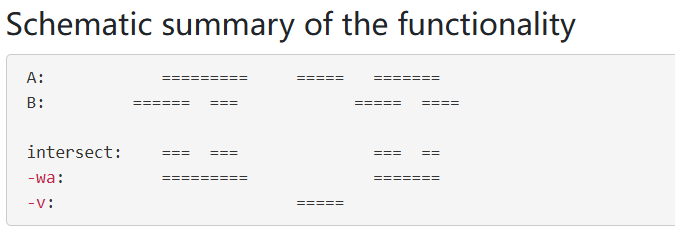

In [ ]:
# convert the candidate sites into a BED file
def get_variant_df_bed_format(variant_df):
    bed_records = []
    for _, row in variant_df.iterrows():
        chrom = row['chr']
        start = row['pos'] - 1  # BED format is 0-based
        end = row['pos']        # BED format end is exclusive
        name = '@'.join([str(row['ref']), str(row['alt']), str(row['coverage']), str(row['alt_count']), str(row['var_freq'])])
        bed_records.append([chrom, start, end, name])
    bed_df = pd.DataFrame(bed_records, columns=['chrom', 'start', 'end', 'name'])
    return bed_df

bed_df_ADAR_WT = get_variant_df_bed_format(df_ADAR_WT_variantsites_homozygous)
bed_df_ADAR_KO = get_variant_df_bed_format(df_ADAR_KO_variantsites_homozygous)

print("ADAR_WT variant sites in BED format:")
display(bed_df_ADAR_WT)

print("ADAR_KO variant sites in BED format:")
display(bed_df_ADAR_KO)

ADAR_WT variant sites in BED format:


,chrom,start,end,name
0,chr1,16974729,16974730,T@C@2@2@1.0
1,chr1,16975107,16975108,T@G@2@2@1.0
2,chr1,16975284,16975285,A@G@107@107@1.0
3,chr1,16976220,16976221,A@G@16@2@0.125
4,chr1,16977093,16977094,C@T@4@4@1.0
...,...,...,...,...
1114,chrX,154365711,154365712,T@C@4@2@0.5
1115,chrX,154365721,154365722,A@C@4@2@0.5
1116,chrX,154366166,154366167,G@A@211@211@1.0
1117,chrX,154368265,154368266,G@A@7@2@0.286


ADAR_KO variant sites in BED format:


,chrom,start,end,name
0,chr1,16974963,16974964,G@A@72@2@0.028
1,chr1,16975284,16975285,A@G@121@121@1.0
2,chr1,16975627,16975628,C@A@6@2@0.333
3,chr1,16976084,16976085,G@A@26@2@0.077
4,chr1,16977093,16977094,C@T@3@3@1.0
...,...,...,...,...
902,chrX,154357211,154357212,C@G@31@2@0.065
903,chrX,154365711,154365712,T@C@6@4@0.667
904,chrX,154366166,154366167,G@A@221@217@0.982
905,chrX,154368108,154368109,C@G@7@2@0.286


In [ ]:
def remove_SNP(variant_df, snp_bed):

    # load SNP bed
    variant_bed = pybedtools.BedTool.from_dataframe(variant_df[['chrom','start','end','name']])

    #  use bedtools to subtract the known SNP sites from our candidate sites
    variant_sites_noSNP_bed = variant_bed.intersect(snp_bed, v=True) # v=True: exclude overlapping
    variant_sites_noSNP_df = variant_sites_noSNP_bed.to_dataframe(names=['chrom','start','end','name'])

    return variant_sites_noSNP_df

In [ ]:
# invoke 'remove_SNP' function on ADAR_WT and ADAR_KO variant bed data
snp_bed_path = pybedtools.BedTool('./data/reference/hg38_SNP.bed')

ADAR_WT_variantsites_noSNP_df = remove_SNP(bed_df_ADAR_WT, snp_bed_path)
ADAR_KO_variantsites_noSNP_df = remove_SNP(bed_df_ADAR_KO, snp_bed_path)

# number: before and after removing SNPs
print("Number of ADAR_WT variant sites before removing SNPs: %s, after removing SNPs: %s" % (len(bed_df_ADAR_WT), len(ADAR_WT_variantsites_noSNP_df)))
print("Number of ADAR_KO variant sites before removing SNPs: %s, after removing SNPs: %s" % (len(bed_df_ADAR_KO), len(ADAR_KO_variantsites_noSNP_df)))
print()

print("ADAR_WT variant sites after removing SNPs:")
display(ADAR_WT_variantsites_noSNP_df)

print("ADAR_KO variant sites after removing SNPs:")
display(ADAR_KO_variantsites_noSNP_df)

Number of ADAR_WT variant sites before removing SNPs: 1119, after removing SNPs: 835
Number of ADAR_KO variant sites before removing SNPs: 907, after removing SNPs: 599

ADAR_WT variant sites after removing SNPs:


,chrom,start,end,name
0,chr1,16974729,16974730,T@C@2@2@1.0
1,chr1,16975107,16975108,T@G@2@2@1.0
2,chr1,16976220,16976221,A@G@16@2@0.125
3,chr1,16977636,16977637,T@G@2@2@1.0
4,chr1,16977787,16977788,T@G@2@2@1.0
...,...,...,...,...
830,chrX,154365622,154365623,A@G@5@2@0.4
831,chrX,154365711,154365712,T@C@4@2@0.5
832,chrX,154365721,154365722,A@C@4@2@0.5
833,chrX,154368265,154368266,G@A@7@2@0.286


ADAR_KO variant sites after removing SNPs:


,chrom,start,end,name
0,chr1,16974963,16974964,G@A@72@2@0.028
1,chr1,16975627,16975628,C@A@6@2@0.333
2,chr1,16976084,16976085,G@A@26@2@0.077
3,chr1,16977442,16977443,A@T@4@2@0.5
4,chr1,115815227,115815228,G@A@2@2@1.0
...,...,...,...,...
594,chrX,154356863,154356864,T@C@25@2@0.08
595,chrX,154356959,154356960,T@A@14@2@0.143
596,chrX,154357211,154357212,C@G@31@2@0.065
597,chrX,154365711,154365712,T@C@6@4@0.667


##### 4） Separate Alu and non-Alu mismatches

In [ ]:
def saparate_Alu_nonAlu_sites(variant_df, alu_bed):
    # load variant bed
    variant_bed = pybedtools.BedTool.from_dataframe(variant_df[['chrom','start','end','name']])

    # bedtools intersect to get Alu sites
    variant_sites_Alu_bed = variant_bed.intersect(alu_bed, u=True) # u=True: report only those that have overlaps
    variant_sites_Alu_df = variant_sites_Alu_bed.to_dataframe(names=['chrom','start','end','name'])

    # bedtools intersect to get non-Alu sites
    variant_sites_nonAlu_bed = variant_bed.intersect(alu_bed, v=True) # v=True: exclude overlapping
    variant_sites_nonAlu_df = variant_sites_nonAlu_bed.to_dataframe(names=['chrom','start','end','name'])

    return variant_sites_Alu_df, variant_sites_nonAlu_df

In [ ]:
# invoke 'saparate_Alu_nonAlu_sites' function on ADAR_WT and ADAR_KO variant bed data after removing SNPs

Alu_bed_path = pybedtools.BedTool('./data/reference/hg38_Alu.bed')
ADAR_WT_variantsites_Alu, ADAR_WT_variantsites_nonAlu = saparate_Alu_nonAlu_sites(ADAR_WT_variantsites_noSNP_df, Alu_bed_path)
ADAR_KO_variantsites_Alu, ADAR_KO_variantsites_nonAlu = saparate_Alu_nonAlu_sites(ADAR_KO_variantsites_noSNP_df, Alu_bed_path)

# number: Alu and non-Alu sites
# the non-Alu mismatches will go through a second,more stringent round of filtering to identify the true RNA editing sites.
print("ADAR_WT variant sites in Alu regions: %s, in non-Alu regions: %s" % (len(ADAR_WT_variantsites_Alu), len(ADAR_WT_variantsites_nonAlu)))
print("ADAR_KO variant sites in Alu regions: %s, in non-Alu regions: %s" % (len(ADAR_KO_variantsites_Alu), len(ADAR_KO_variantsites_nonAlu)))

ADAR_WT variant sites in Alu regions: 241, in non-Alu regions: 594
ADAR_KO variant sites in Alu regions: 61, in non-Alu regions: 538


In [ ]:
# save
ADAR_WT_variantsites_Alu.to_csv(os.path.join(EDITING_DIR, 'ADAR_WT_Alu_sites.txt'), sep='\t', header=False, index=False)
ADAR_KO_variantsites_Alu.to_csv(os.path.join(EDITING_DIR, 'ADAR_KO_Alu_sites.txt'), sep='\t', header=False, index=False)

#### Filters-2 -> for 'non-Alu mismatches' : get 'Repetitive non-Alu editing sites' and 'Nonrepetitive editing sites'
        
        1)
        min_variant_count >=3; min_variant_frequency >= 0.1
        2)
        remove sites in simple repeats
        3)
        Filter intronic sites within 4 bp of splice junctions
        4)
        remove sites in homopolymer runs of >= 5bp
        5)
        BLAT reads with mismatch against reference genome to ensure unique mapping
#### Data
        1)  Non-Alu mismatches data
        2)  required filter files:
                        1 - NonAlu-repeat region data
                        2 - simple repeat region data (data from repeatmasker)
                        3 - splice junctions region data (get from GTF)
                        4 - reference fa filte - to BLAT


#### 1 - prepare the splice junctions data、 simple repeat data、 NonAlu-repeat region data

In [ ]:
def generate_splice_site_bed(gtf_file, flank=4):
    # 1. read GTF file and extract exon features
    gtf_df = pd.read_csv(
        gtf_file, sep='\t', comment='#', header=None,
        names=['chr','source','feature','start','end','score','strand','frame','attribute']
    )
    exons = gtf_df[gtf_df['feature'] == 'exon'].copy()

    # BED is 0-based, half-open
    exons['start0'] = exons['start'] - 1

    # 2. generate splice site regions with flanking sequences
    splice_regions = []
    for _, row in exons.iterrows():
        # 5' splice site
        splice_regions.append([row['chr'], max(0,row['start0'] - flank), row['start0'] + flank])
        # 3' splice site
        splice_regions.append([row['chr'], max(0,row['end'] - flank), row['end'] + flank])

    splice_bed = pd.DataFrame(splice_regions, columns=['chrom','start','end'])
    splice_bed.to_csv(f'./data/reference/hg38_splice_sites_flank{flank}bp.bed', sep='\t', index=False, header=False)

    return splice_bed

# generate splice site bed file with 4bp flanking sequences
splice_bed = generate_splice_site_bed(GTF, flank=4)
print("Splice site regions with 4bp flanking sequences:")
display(splice_bed)

Splice site regions with 4bp flanking sequences:


,chrom,start,end
0,chr1,11116,11124
1,chr1,11207,11215
2,chr1,12005,12013
3,chr1,12223,12231
4,chr1,12608,12616
...,...,...,...
7347893,chrM,15883,15891
7347894,chrM,15883,15891
7347895,chrM,15949,15957
7347896,chrM,15951,15959


In [ ]:
# show simple repeat region data

SimpleRepeat_df = pd.read_csv('./data/reference/hg38_simple_repeat.bed', sep = '\t', header = None, names=['chrom', 'start', 'end'])
print('Simple repeat region：')
display(SimpleRepeat_df)

nonAlu_repeat_df = pd.read_csv('./data/reference/hg38_nonAlu_repeat.bed', sep = '\t', header = None, names=['chrom', 'start', 'end'])
print('Non-Alu repeat region：')
display(nonAlu_repeat_df)

Simple repeat region：


,chrom,start,end
0,chr1,12582784,12583841
1,chr1,12582839,12582993
2,chr1,12582910,12583333
3,chr1,22020082,22020671
4,chr1,121609878,121734316
...,...,...,...
1049710,chr22_KI270739v1_random,42428,42470
1049711,chr22_KI270739v1_random,42529,60923
1049712,chr22_KI270739v1_random,42644,60923
1049713,chr22_KI270739v1_random,50068,61010


Non-Alu repeat region：


,chrom,start,end
0,chr1,67108753,67109046
1,chr1,25165803,25166380
2,chr1,50331336,50332274
3,chr1,58719764,58720546
4,chr1,75496057,75497775
...,...,...,...
4400864,chr22_KI270739v1_random,42471,42520
4400865,chr22_KI270739v1_random,42530,48656
4400866,chr22_KI270739v1_random,48656,49096
4400867,chr22_KI270739v1_random,49091,50070


#### 2 - Filter:
        1)
        more stringent variant call criteria:min_variant_count >=3; min_variant_frequency >= 0.1
        2)
        remove sites in simple repeats
        3)
        Filter intronic sites within 4 bp of splice junctions
        4)
        remove sites in homopolymer runs of >= 5bp
        5)
        BLAT reads with mismatch against reference genome to ensure unique mapping

##### 1） more stringent variant call criteria:min_variant_count >=3; min_variant_frequency >= 0.1

In [ ]:
def stringent_criteria_filter(variant_df, min_variant_count=3, min_variant_frequency=0.1):
  # we require the number of variant reads to be at least 3, and the variant ratio to be greater than 1 percent.
    variant_df['var_count'] = variant_df['name'].str.split('@').str[3].astype(int)
    variant_df['varFreq'] = variant_df['name'].str.split('@').str[4].astype(float)
    variant_df = variant_df[
        (variant_df['var_count'] >= 3) &
        (variant_df['varFreq'] >= 0.1)
    ]

    variant_df = variant_df.drop(columns=['var_count', 'varFreq'])
    return variant_df

In [ ]:
# invoke 'stringent_criteria_filter' function on ADAR_WT and ADAR_KO non-Alu variant bed data

ADAR_WT_variantsites_nonAlu_stringent = stringent_criteria_filter(ADAR_WT_variantsites_nonAlu)
ADAR_KO_variantsites_nonAlu_stringent = stringent_criteria_filter(ADAR_KO_variantsites_nonAlu)

# number: before and after stringent criteria filtering
print("ADAR_WT non-Alu variant sites before stringent filtering: %s, after stringent filtering: %s" % (len(ADAR_WT_variantsites_nonAlu), len(ADAR_WT_variantsites_nonAlu_stringent)))
print("ADAR_KO non-Alu variant sites before stringent filtering: %s, after stringent filtering: %s" % (len(ADAR_KO_variantsites_nonAlu), len(ADAR_KO_variantsites_nonAlu_stringent)))

print("ADAR_WT non-Alu variant sites after stringent filtering:")
display(ADAR_WT_variantsites_nonAlu_stringent.head())

print("ADAR_KO non-Alu variant sites after stringent filtering:")
display(ADAR_KO_variantsites_nonAlu_stringent.head())

ADAR_WT non-Alu variant sites before stringent filtering: 594, after stringent filtering: 30
ADAR_KO non-Alu variant sites before stringent filtering: 538, after stringent filtering: 19
ADAR_WT non-Alu variant sites after stringent filtering:


,chrom,start,end,name
20,chr1,144421987,144421988,T@C@30@4@0.133
27,chr1,144426380,144426381,C@T@8@8@1.0
42,chr1,144447182,144447183,G@A@7@4@0.571
60,chr1,160317393,160317394,T@C@5@4@0.8
72,chr2,37100518,37100519,T@C@67@21@0.313


ADAR_KO non-Alu variant sites after stringent filtering:


,chrom,start,end,name
22,chr1,144426380,144426381,C@T@5@5@1.0
71,chr2,37100842,37100843,G@A@89@42@0.472
139,chr4,90838991,90838992,G@A@41@41@1.0
141,chr4,90839054,90839055,G@A@44@44@1.0
142,chr4,90839055,90839056,G@A@44@44@1.0


##### 2） remove sites in simple repeats
      tool: bedtools

In [ ]:
def remove_simple_repeat_regions(nonAlu_variant_df, simple_repeat_bed):
    # load variant bed
    variant_bed = pybedtools.BedTool.from_dataframe(nonAlu_variant_df[['chrom','start','end','name']])

    # bedtools intersect to exclude simple repeat regions
    variant_sites_noSimpleRepeat_bed = variant_bed.intersect(simple_repeat_bed, v=True) # v=True: exclude overlapping
    variant_sites_noSimpleRepeat_df = variant_sites_noSimpleRepeat_bed.to_dataframe(names=['chrom','start','end','name'])

    return variant_sites_noSimpleRepeat_df

In [ ]:
# invoke 'remove_simple_repeat_regions' function on ADAR_WT and ADAR_KO non-Alu stringent variant bed data
simple_repeat_bed_path = pybedtools.BedTool('./data/reference/hg38_simple_repeat.bed')

ADAR_WT_variantsites_nonAlu_noSimpleRepeat = remove_simple_repeat_regions(ADAR_WT_variantsites_nonAlu_stringent, simple_repeat_bed_path)
ADAR_KO_variantsites_nonAlu_noSimpleRepeat = remove_simple_repeat_regions(ADAR_KO_variantsites_nonAlu_stringent, simple_repeat_bed_path)

# number: before and after removing simple repeat regions
print("ADAR_WT non-Alu variant sites before removing simple repeat regions: %s, after removing simple repeat regions: %s" % (len(ADAR_WT_variantsites_nonAlu_stringent), len(ADAR_WT_variantsites_nonAlu_noSimpleRepeat)))
print("ADAR_KO non-Alu variant sites before removing simple repeat regions: %s, after removing simple repeat regions: %s" % (len(ADAR_KO_variantsites_nonAlu_stringent), len(ADAR_KO_variantsites_nonAlu_noSimpleRepeat)))

print("ADAR_WT non-Alu variant sites after removing simple repeat regions:")
display(ADAR_WT_variantsites_nonAlu_noSimpleRepeat.head())
print("ADAR_KO non-Alu variant sites after removing simple repeat regions:")
display(ADAR_KO_variantsites_nonAlu_noSimpleRepeat.head())

ADAR_WT non-Alu variant sites before removing simple repeat regions: 30, after removing simple repeat regions: 25
ADAR_KO non-Alu variant sites before removing simple repeat regions: 19, after removing simple repeat regions: 17
ADAR_WT non-Alu variant sites after removing simple repeat regions:


,chrom,start,end,name
0,chr1,144421987,144421988,T@C@30@4@0.133
1,chr1,144447182,144447183,G@A@7@4@0.571
2,chr1,160317393,160317394,T@C@5@4@0.8
3,chr2,37100518,37100519,T@C@67@21@0.313
4,chr2,37100558,37100559,T@C@73@8@0.11


ADAR_KO non-Alu variant sites after removing simple repeat regions:


,chrom,start,end,name
0,chr2,37100842,37100843,G@A@89@42@0.472
1,chr4,90838991,90838992,G@A@41@41@1.0
2,chr4,90839054,90839055,G@A@44@44@1.0
3,chr4,90839055,90839056,G@A@44@44@1.0
4,chr4,90839066,90839067,G@A@42@42@1.0


##### 3） filter intronic sites within 4bp of splice junctions

In [ ]:
def filter_near_splice_sites(variant_df, splice_bed):
    # load variant bed
    variant_bed = pybedtools.BedTool.from_dataframe(variant_df[['chrom','start','end','name']])

    # bedtools intersect to exclude sites near splice sites
    variant_sites_noSplice_bed = variant_bed.intersect(splice_bed, v=True) # v=True: exclude overlapping
    variant_sites_noSplice_df = variant_sites_noSplice_bed.to_dataframe(names=['chrom','start','end','name'])

    return variant_sites_noSplice_df

In [ ]:
# invoke 'filter_near_splice_sites' function on ADAR_WT and ADAR_KO non-Alu stringent variant bed data after removing simple repeat regions

splice_bed_path = pybedtools.BedTool('./data/reference/hg38_splice_sites_flank4bp.bed')
ADAR_WT_nonAlu_rm_splice = filter_near_splice_sites(ADAR_WT_variantsites_nonAlu_noSimpleRepeat, splice_bed_path)
ADAR_KO_nonAlu_rm_splice = filter_near_splice_sites(ADAR_KO_variantsites_nonAlu_noSimpleRepeat, splice_bed_path)

# number: before and after removing sites near splice sites
print("ADAR_WT non-Alu variant sites before removing splice site nearby: %s, after removing splice site nearby: %s" % (len(ADAR_WT_variantsites_nonAlu_noSimpleRepeat), len(ADAR_WT_nonAlu_rm_splice)))
print("ADAR_KO non-Alu variant sites before removing splice site nearby: %s, after removing splice site nearby: %s" % (len(ADAR_KO_variantsites_nonAlu_noSimpleRepeat), len(ADAR_KO_nonAlu_rm_splice)))

print("ADAR_WT non-Alu variant sites after removing splice site nearby:")
display(ADAR_WT_nonAlu_rm_splice.head())
print("ADAR_KO non-Alu variant sites after removing splice site nearby:")
display(ADAR_KO_nonAlu_rm_splice.head())

ADAR_WT non-Alu variant sites before removing splice site nearby: 25, after removing splice site nearby: 24
ADAR_KO non-Alu variant sites before removing splice site nearby: 17, after removing splice site nearby: 16
ADAR_WT non-Alu variant sites after removing splice site nearby:


,chrom,start,end,name
0,chr1,144421987,144421988,T@C@30@4@0.133
1,chr1,144447182,144447183,G@A@7@4@0.571
2,chr1,160317393,160317394,T@C@5@4@0.8
3,chr2,37100518,37100519,T@C@67@21@0.313
4,chr2,37100558,37100559,T@C@73@8@0.11


ADAR_KO non-Alu variant sites after removing splice site nearby:


,chrom,start,end,name
0,chr2,37100842,37100843,G@A@89@42@0.472
1,chr4,90838991,90838992,G@A@41@41@1.0
2,chr4,90839054,90839055,G@A@44@44@1.0
3,chr4,90839055,90839056,G@A@44@44@1.0
4,chr4,90839066,90839067,G@A@42@42@1.0


##### 4） remove sites in homopolymer runs of >= 5bp

In [ ]:
def remove_homoplymer_regions(variant_df, ref_fa):

    def remove_homoplymer(candidate_site_bed_row, ref_fa, homo_length):
        line = candidate_site_bed_row
        chrom = line.iloc[0]
        pos = line.iloc[2]   # 1-based

        genome = pysam.FastaFile(ref_fa)
        up_homo =  genome.fetch( chrom, pos - homo_length - 1, pos - 1 ).upper()
        down_homo = genome.fetch( chrom, pos , pos + homo_length ).upper()
        inter_homo = up_homo[-int(homo_length/2)-1:] + down_homo[0:int(homo_length/2)+1]

        bool_homo = (len(set(up_homo)) == 1) or (len(set(down_homo)) == 1) or (len(set(inter_homo)) == 1)
        if bool_homo:
            return True
        else:
            return False

    variant_df['isHomopolymer'] = variant_df.apply(lambda x:remove_homoplymer(x, ref_fa, 5), axis=1)
    variant_rm_homo_df = variant_df[ variant_df['isHomopolymer'] == False ].iloc[:, :4]

    return variant_rm_homo_df

In [ ]:
# invoke 'remove_homoplymer_regions' function on ADAR_WT and ADAR_KO non-Alu variant bed data

ref_fa = './data/reference/hg38.fa'
ADAR_WT_nonAlu_rm_homo = remove_homoplymer_regions(ADAR_WT_nonAlu_rm_splice, REF_fa)
ADAR_KO_nonAlu_rm_homo = remove_homoplymer_regions(ADAR_KO_nonAlu_rm_splice, REF_fa)

# number: before and after removing homopolymer
print("ADAR_WT non-Alu variant sites before removing homopolymer: %s, after removing homopolymer: %s" % (len(ADAR_WT_nonAlu_rm_splice), len(ADAR_WT_nonAlu_rm_homo)))
print("ADAR_KO non-Alu variant sites before removing homopolymer: %s, after removing homopolymer: %s" % (len(ADAR_KO_nonAlu_rm_splice), len(ADAR_KO_nonAlu_rm_homo)))

print()

print("ADAR_WT non-Alu variant sites after removing homopolymer:")
display(ADAR_WT_nonAlu_rm_homo.head())
print("ADAR_KO non-Alu variant sites after removing homopolymer:")
display(ADAR_KO_nonAlu_rm_homo.head())

# save
ADAR_WT_nonAlu_rm_homo.to_csv(os.path.join(EDITING_DIR, 'ADAR_WT_nonAlu_sites.txt'), sep='\t', header=False, index=False)
ADAR_KO_nonAlu_rm_homo.to_csv(os.path.join(EDITING_DIR, 'ADAR_KO_nonAlu_sites.txt'), sep='\t', header=False, index=False)

ADAR_WT non-Alu variant sites before removing homopolymer: 24, after removing homopolymer: 24
ADAR_KO non-Alu variant sites before removing homopolymer: 16, after removing homopolymer: 15

ADAR_WT non-Alu variant sites after removing homopolymer:


,chrom,start,end,name
0,chr1,144421987,144421988,T@C@30@4@0.133
1,chr1,144447182,144447183,G@A@7@4@0.571
2,chr1,160317393,160317394,T@C@5@4@0.8
3,chr2,37100518,37100519,T@C@67@21@0.313
4,chr2,37100558,37100559,T@C@73@8@0.11


ADAR_KO non-Alu variant sites after removing homopolymer:


,chrom,start,end,name
0,chr2,37100842,37100843,G@A@89@42@0.472
1,chr4,90838991,90838992,G@A@41@41@1.0
2,chr4,90839054,90839055,G@A@44@44@1.0
3,chr4,90839055,90839056,G@A@44@44@1.0
4,chr4,90839066,90839067,G@A@42@42@1.0


##### 5） BLAT reads with mismatch against reference genome to ensure unique mapping
            1. Requirement (i): best hit overlaps the candidate site
            2. Requirement (ii): second-best hit score < 95% of best hit
            3. Keep sites where passing reads > failing reads

In [ ]:
def blat_filter_nonAlu_sites(site_file, bam_file, ref_fa, output_file,
                                  min_basequal=25, min_mismatch=2, score_limit=0.95,
                                  blat_bin="./data/blat"):
    """
    1. Extract reads covering each site from the BAM file
    2. Filter reads based on base quality and edited nucleotides
    3. Generate the fatmp FASTA file
    4. Align reads to the reference genome using BLAT
    5. Parse the PSL file and filter reads
    6. Count editing events at each site and output the final table
    """
    fatmp_file = Path(site_file + ".fatmp")
    psl_file = Path(site_file + ".psltmp")

    bam = pysam.AlignmentFile(bam_file, "rb")

    site_df = pd.read_csv(site_file, sep="\t", header=None, dtype={0:str, 1:int, 2:int, 3:str})

    # -----------------------------
    # 1. get reads, generate fatmp
    # -----------------------------
    with open(fatmp_file, "w") as fafile:
        for idx, row in site_df.iterrows():
            chrom = row[0]
            pos = int(row[1])
            # column 4 format: ref@alt@cov@alt_count@ratio
            fields = row[3].split("@")
            ref_base = fields[0]
            alt_base = fields[1]
            tmp_reads_file = f"{output_file}_tmp"

            reads = list(bam.fetch(chrom, pos-1, pos))
            mismatch_readcount = 0

            for r in reads:
                ref_pos = r.reference_start
                seq = r.query_sequence
                qual = r.query_qualities
                cigar_tuples = r.cigartuples
                if cigar_tuples is None:
                    continue

                ref_cursor = ref_pos
                read_cursor = 0
                base_match = False

                for op, length in cigar_tuples:
                    if op in (0, 7, 8):  # M, =, X
                        for i in range(length):
                            if ref_cursor == pos-1 and seq[read_cursor].upper() == alt_base and qual[read_cursor] >= min_basequal:
                                base_match = True
                            ref_cursor += 1
                            read_cursor += 1
                    elif op in (1, 4, 5):  # I, S, H
                        read_cursor += length
                    elif op in (2, 3):  # D, N
                        ref_cursor += length

                if base_match:
                    fafile.write(f">{chrom}-{pos}-{mismatch_readcount}\n{seq}\n")
                    mismatch_readcount += 1

    # -----------------------------
    # 2. BLAT
    # -----------------------------
    subprocess.run(f"{blat_bin} -stepSize=5 -repMatch=2253 -minScore=20 -minIdentity=0 -noHead {ref_fa} {fatmp_file} {psl_file}",
                   shell=True, check=True)

    # -----------------------------
    # 3. parse PSL
    # -----------------------------
    pslhash = {}
    with open(psl_file) as f:
        for line in f:
            fields = line.strip().split()
            name = fields[9]
            blatscore = "@".join([fields[0], fields[13], fields[17], fields[18], fields[20]])
            if name in pslhash:
                pslhash[name] = f"{pslhash[name]}-{blatscore}"
            else:
                pslhash[name] = blatscore

    # -----------------------------
    # 4. filter PSL results
    # -----------------------------
    sitehash = {}
    discardhash = {}

    for key, val in pslhash.items():
        key_parts = key.split("-")
        site_key = f"{key_parts[0]}_{key_parts[1]}"
        psllines = val.split("-")

        scores = []
        largest_score = 0
        largest_line = psllines[0]
        for line in psllines:
            s = int(line.split("@")[0])
            scores.append(s)
            if s > largest_score:
                largest_line = line
                largest_score = s
        scores.sort(reverse=True)
        second_score = scores[1] if len(scores) > 1 else 0

        split_line = largest_line.split("@")
        overlap_found = False
        if split_line[1] == key_parts[0] and second_score < largest_score * score_limit:
            numblocks = int(split_line[2])
            blocksizes = list(map(int, split_line[3].strip(",").split(",")))
            blockstarts = list(map(int, split_line[4].strip(",").split(",")))
            for bs, start in zip(blocksizes, blockstarts):
                startpos = start + 1
                endpos = start + bs
                if int(key_parts[1]) >= startpos and int(key_parts[1]) <= endpos:
                    overlap_found = True
                    break
        if overlap_found:
            sitehash[site_key] = sitehash.get(site_key, 0) + 1
        else:
            discardhash[site_key] = discardhash.get(site_key, 0) + 1

    # -----------------------------
    # 5. output final results
    # -----------------------------
    with open(output_file, "w") as out_f:
        for idx, row in site_df.iterrows():
            chrom = row[0]
            pos = str(row[1])
            fields = row[3].split("@")
            cov = int(fields[2])
            oldalter = int(fields[3])
            site_key = f"{chrom}_{pos}"
            newalter = sitehash.get(site_key, 0)
            discardnum = discardhash.get(site_key, 0)
            newcov = cov - (oldalter - newalter)
            neweditfreq = round(newalter / newcov, 3) if newcov > 0 else 0
            if newalter >= min_mismatch and newalter > discardnum:
                out_f.write(f"{chrom}\t{int(pos)-1}\t{pos}\t{fields[0]}@{fields[1]}@{newcov}@{newalter}@{neweditfreq}\n")

    # os.remove(fatmp_file)
    # os.remove(psl_file)


In [ ]:
# invoke 'blat_filter_nonAlu_sites' function on ADAR_WT and ADAR_KO non-Alu sites
blat_filter_nonAlu_sites(
    site_file='./data/4_editing/ADAR_WT_nonAlu_sites.txt',
    bam_file='./data/2_dedup_bam/ADAR_WT_dePCRdup.bam',
    ref_fa=REF_fa,
    output_file='./data/4_editing/ADAR_WT_nonAlu_blat_filtered.txt',
    min_basequal=25,
    min_mismatch=2,
    score_limit=0.95,
    blat_bin="/public/home/lix/bin/x86_64/blat"
)

blat_filter_nonAlu_sites(
    site_file='./data/4_editing/ADAR_KO_nonAlu_sites.txt',
    bam_file='./data/2_dedup_bam/ADAR_KO_dePCRdup.bam',
    ref_fa=REF_fa,
    output_file='./data/4_editing/ADAR_KO_nonAlu_blat_filtered.txt',
    min_basequal=25,
    min_mismatch=2,
    score_limit=0.95,
    blat_bin="/public/home/lix/bin/x86_64/blat"
)

# number: before and after BLAT filtering
try:
    ADAR_WT_nonAlu_blat_filtered_df = pd.read_csv(
        './data/4_editing/ADAR_WT_nonAlu_blat_filtered.txt',
        sep='\t', header=None
    )
except pd.errors.EmptyDataError:
    ADAR_WT_nonAlu_blat_filtered_df = pd.DataFrame()

try:
    ADAR_KO_nonAlu_blat_filtered_df = pd.read_csv(
        './data/4_editing/ADAR_KO_nonAlu_blat_filtered.txt',
        sep='\t', header=None
    )
except pd.errors.EmptyDataError:
    ADAR_KO_nonAlu_blat_filtered_df = pd.DataFrame()

print()

print("ADAR_WT non-Alu variant sites before Blat: %s, after Blat: %s" % (len(ADAR_WT_nonAlu_rm_homo), len(ADAR_WT_nonAlu_blat_filtered_df)))
print("ADAR_KO non-Alu variant sites before Blat: %s, after Blat: %s" % (len(ADAR_KO_nonAlu_rm_homo), len(ADAR_KO_nonAlu_blat_filtered_df)))

print()

print("ADAR_WT non-Alu variant sites after Blat:")
display(ADAR_WT_nonAlu_blat_filtered_df.head())
print("ADAR_KO non-Alu variant sites after Blat:")
display(ADAR_KO_nonAlu_blat_filtered_df.head())

Loaded 3099750718 letters in 194 sequences
Searched 47802 bases in 337 sequences
Loaded 3099750718 letters in 194 sequences
Searched 6570 bases in 48 sequences

ADAR_WT non-Alu variant sites before Blat: 24, after Blat: 4
ADAR_KO non-Alu variant sites before Blat: 15, after Blat: 0

ADAR_WT non-Alu variant sites after Blat:


,0,1,2,3
0,chr2,37100517,37100518,T@C@115@69@0.6
1,chr2,37100557,37100558,T@C@140@75@0.536
2,chr2,37100952,37100953,T@C@138@74@0.536
3,chr20,37519159,37519160,T@C@146@77@0.527


ADAR_KO non-Alu variant sites after Blat:


""


##### 6） Separate editing sites in repetitive and nonrepetitive regions

In [ ]:
def Separate_rep_nonrep_sites(variant_file, nonAlu_repeat_bed, output_rep_file, output_nonrep_file):
    # load variant bed
    variant_df = pd.read_csv(variant_file, sep='\t', header=None, names=['chrom','start','end','name'])
    variant_bed = pybedtools.BedTool.from_dataframe(variant_df)

    # bedtools intersect to get repeat sites
    variant_sites_rep_bed = variant_bed.intersect(nonAlu_repeat_bed, u=True) # u=True: report only those that have overlaps
    variant_sites_rep_df = variant_sites_rep_bed.to_dataframe(names=['chrom','start','end','name'])

    # bedtools intersect to get non-repeat sites
    variant_sites_nonrep_bed = variant_bed.intersect(nonAlu_repeat_bed, v=True) # v=True: exclude overlapping
    variant_sites_nonrep_df = variant_sites_nonrep_bed.to_dataframe(names=['chrom','start','end','name'])

    # save
    variant_sites_rep_df.to_csv(output_rep_file, sep='\t', header=False, index=False)
    variant_sites_nonrep_df.to_csv(output_nonrep_file, sep='\t', header=False, index=False)

    return variant_sites_rep_df, variant_sites_nonrep_df

In [ ]:
# invoke 'Separate_rep_nonrep_sites' function on ADAR_WT and ADAR_KO non-Alu blat filtered variant bed data

nonAlu_repeat_bed_path = pybedtools.BedTool('./data/reference/hg38_nonAlu_repeat.bed')
ADAR_WT_nonAlu_rep, ADAR_WT_nonAlu_nonrep = Separate_rep_nonrep_sites(
    variant_file='./data/4_editing/ADAR_WT_nonAlu_blat_filtered.txt',
    nonAlu_repeat_bed=nonAlu_repeat_bed_path,
    output_rep_file='./data/4_editing/ADAR_WT_nonAlu_repeat_sites.txt',
    output_nonrep_file='./data/4_editing/ADAR_WT_nonAlu_nonrepeat_sites.txt'
)

ADAR_KO_nonAlu_rep, ADAR_KO_nonAlu_nonrep = Separate_rep_nonrep_sites(
    variant_file='./data/4_editing/ADAR_KO_nonAlu_blat_filtered.txt',
    nonAlu_repeat_bed=nonAlu_repeat_bed_path,
    output_rep_file='./data/4_editing/ADAR_KO_nonAlu_repeat_sites.txt',
    output_nonrep_file='./data/4_editing/ADAR_KO_nonAlu_nonrepeat_sites.txt'
)

# number: repeat and non-repeat sites
print("ADAR_WT non-Alu variant sites in repeat regions: %s, in non-repeat regions: %s" % (len(ADAR_WT_nonAlu_rep), len(ADAR_WT_nonAlu_nonrep)))
print("ADAR_KO non-Alu variant sites in repeat regions: %s, in non-repeat regions: %s" % (len(ADAR_KO_nonAlu_rep), len(ADAR_KO_nonAlu_nonrep)))

ADAR_WT non-Alu variant sites in repeat regions: 0, in non-repeat regions: 4
ADAR_KO non-Alu variant sites in repeat regions: 0, in non-repeat regions: 0


### Step 4 - Results Analysis
#### Files -
        1. Alu.sites
        2. nonAlu_Rep.sites
        3. nonAlu_nonRep.sites

##### 1 - show the numbers of editing sites

In [ ]:
# ADAR_KO all final results
ADAR_KO_Alu = pd.read_csv(os.path.join(EDITING_DIR, 'ADAR_KO_Alu_sites.txt'), sep='\t', header=None, names=['chrom','start','end','name'])
ADAR_KO_nonAlu_repeat = pd.read_csv(os.path.join(EDITING_DIR, 'ADAR_KO_nonAlu_repeat_sites.txt'), sep='\t', header=None, names=['chrom','start','end','name'])
ADAR_KO_nonAlu_nonrepeat = pd.read_csv(os.path.join(EDITING_DIR, 'ADAR_KO_nonAlu_nonrepeat_sites.txt'), sep='\t', header=None, names=['chrom','start','end','name'])

# ADAR_WT all final results
ADAR_WT_Alu = pd.read_csv(os.path.join(EDITING_DIR, 'ADAR_WT_Alu_sites.txt'), sep='\t', header=None, names=['chrom','start','end','name'])
ADAR_WT_nonAlu_repeat = pd.read_csv(os.path.join(EDITING_DIR, 'ADAR_WT_nonAlu_repeat_sites.txt'), sep='\t', header=None, names=['chrom','start','end','name'])
ADAR_WT_nonAlu_nonrepeat = pd.read_csv(os.path.join(EDITING_DIR, 'ADAR_WT_nonAlu_nonrepeat_sites.txt'), sep='\t', header=None, names=['chrom','start','end','name'])

print(f"Final ADAR_WT sites: Alu: {len(ADAR_WT_Alu)}, nonAlu repeat: {len(ADAR_WT_nonAlu_repeat)}, nonAlu non-repeat: {len(ADAR_WT_nonAlu_nonrepeat)}")
print(f"Final ADAR_KO sites: Alu: {len(ADAR_KO_Alu)}, nonAlu repeat: {len(ADAR_KO_nonAlu_repeat)}, nonAlu non-repeat: {len(ADAR_KO_nonAlu_nonrepeat)}")


Final ADAR_WT sites: Alu: 241, nonAlu repeat: 0, nonAlu non-repeat: 4
Final ADAR_KO sites: Alu: 61, nonAlu repeat: 0, nonAlu non-repeat: 0


##### 2 - merge Alu, non-Alu repeat, non-Alu non-repeat sites

In [ ]:
# merge Alu, non-Alu repeat, non-Alu non-repeat sites into one table for ADAR_KO and ADAR_WT respectively
def load_and_parse_sites(df, region_type):
    df = df.copy()

    if df.empty:
        return pd.DataFrame(columns=[
            'chrom', 'start', 'end', 'region_type',
            'ref', 'alt', 'cov', 'mis', 'ediLevel'
        ])

    # region type
    df['region_type'] = region_type

    # parse name 列：ref@alt@cov@mis@ediLevel
    parsed = df['name'].astype(str).str.split('@', expand=True)

    if parsed.shape[1] != 5:
        raise ValueError(f"Unexpected name format in {region_type}")

    parsed.columns = ['ref', 'alt', 'cov', 'mis', 'ediLevel']

    parsed['cov'] = parsed['cov'].astype(int)
    parsed['mis'] = parsed['mis'].astype(int)
    parsed['ediLevel'] = parsed['ediLevel'].astype(float)

    # merge
    df = pd.concat([df.drop(columns='name'), parsed], axis=1)

    return df

ADAR_KO_all = pd.concat([
    load_and_parse_sites(ADAR_KO_Alu, 'Alu'),
    load_and_parse_sites(ADAR_KO_nonAlu_repeat, 'nonAlu_repeat'),
    load_and_parse_sites(ADAR_KO_nonAlu_nonrepeat, 'nonAlu_nonrepeat')
], ignore_index=True)
ADAR_WT_all = pd.concat([
    load_and_parse_sites(ADAR_WT_Alu, 'Alu'),
    load_and_parse_sites(ADAR_WT_nonAlu_repeat, 'nonAlu_repeat'),
    load_and_parse_sites(ADAR_WT_nonAlu_nonrepeat, 'nonAlu_nonrepeat')
], ignore_index=True)

print("Final ADAR_WT editing sites:")
display(ADAR_WT_all)

print("Final ADAR_KO editing sites:")
display(ADAR_KO_all)

Final ADAR_WT editing sites:


/tmp/ipykernel_1750080/488196005.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ADAR_KO_all = pd.concat([
/tmp/ipykernel_1750080/488196005.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ADAR_WT_all = pd.concat([


,chrom,start,end,region_type,ref,alt,cov,mis,ediLevel
0,chr1,144440666,144440667,Alu,G,T,2,2,1.000
1,chr1,144440683,144440684,Alu,A,C,7,2,0.286
2,chr1,144446011,144446012,Alu,T,C,8,8,1.000
3,chr2,37102068,37102069,Alu,A,T,53,2,0.038
4,chr2,37102070,37102071,Alu,T,C,51,11,0.216
...,...,...,...,...,...,...,...,...,...
240,chr20,37505014,37505015,Alu,T,C,4,2,0.500
241,chr2,37100517,37100518,nonAlu_nonrepeat,T,C,115,69,0.600
242,chr2,37100557,37100558,nonAlu_nonrepeat,T,C,140,75,0.536
243,chr2,37100952,37100953,nonAlu_nonrepeat,T,C,138,74,0.536


Final ADAR_KO editing sites:


,chrom,start,end,region_type,ref,alt,cov,mis,ediLevel
0,chr1,144446011,144446012,Alu,T,C,4,4,1.000
1,chr1,160269601,160269602,Alu,G,T,2,2,1.000
2,chr1,160289057,160289058,Alu,C,A,27,2,0.074
3,chr1,160303121,160303122,Alu,C,T,4,2,0.500
4,chr1,160311472,160311473,Alu,G,A,2,2,1.000
...,...,...,...,...,...,...,...,...,...
56,chr19,53578963,53578964,Alu,C,T,94,2,0.021
57,chr19,53579032,53579033,Alu,A,T,66,45,0.682
58,chr19,53579047,53579048,Alu,C,T,63,2,0.032
59,chr19,53579091,53579092,Alu,C,T,47,2,0.043


##### 3 - compare with the editing sites in REDIrepotal database

In [ ]:
# we focused specifically on A-to-G editing sites. We merged A-to-G sites from different genomic regions
# and compared them with known RNA editing sites from the REDIportal database.

ADAR_KO_AG = ADAR_KO_all[
    (ADAR_KO_all['ref'] == 'A') & (ADAR_KO_all['alt'] == 'G') |
    (ADAR_KO_all['ref'] == 'T') & (ADAR_KO_all['alt'] == 'C')
]

ADAR_WT_AG = ADAR_WT_all[
    (ADAR_WT_all['ref'] == 'A') & (ADAR_WT_all['alt'] == 'G') |
    (ADAR_WT_all['ref'] == 'T') & (ADAR_WT_all['alt'] == 'C')
]

REDIrepotal_data = pd.read_csv('./data/reference/REDIportal_known_AG_sites_selected_genes.bed', sep='\t', header=None, usecols=[0,1,2], names=['chrom', 'start', 'end'])

# calculate overlap with REDIportal known A-to-G editing sites
def calculate_REDIportal_overlap(variant_df, REDIportal_df):
    merged_df = variant_df.merge(
        REDIportal_df,
        left_on=['chrom', 'start', 'end'],
        right_on=['chrom', 'start', 'end'],
        how='inner'
    )
    return merged_df

ADAR_KO_AG_REDIportal_overlap = calculate_REDIportal_overlap(ADAR_KO_AG, REDIrepotal_data)
ADAR_WT_AG_REDIportal_overlap = calculate_REDIportal_overlap(ADAR_WT_AG, REDIrepotal_data)

# number of overlapping sites
print("Number of total ADAR_KO A-to-G editing sites: %s" % len(ADAR_KO_AG))
print("Number of ADAR_KO A-to-G editing sites overlapping with REDIportal known sites: %s" % len(ADAR_KO_AG_REDIportal_overlap))
print()
print("Number of total ADAR_WT A-to-G editing sites: %s" % len(ADAR_WT_AG))
print("Number of ADAR_WT A-to-G editing sites overlapping with REDIportal known sites: %s" % len(ADAR_WT_AG_REDIportal_overlap))

Number of total ADAR_KO A-to-G editing sites: 27
Number of ADAR_KO A-to-G editing sites overlapping with REDIportal known sites: 20

Number of total ADAR_WT A-to-G editing sites: 215
Number of ADAR_WT A-to-G editing sites overlapping with REDIportal known sites: 204


##### 4 - calculate the A-G fraction and A-G count in different regions(Alu、 nonAlu、 nonRep)

In [ ]:
# calculate A-to-G / T-to-C editing fraction and counts in different regions for ADAR_KO and ADAR_WT

ADAR_KO_all['condition'] = 'KO'
ADAR_WT_all['condition'] = 'WT'

all_sites = pd.concat([ADAR_KO_all, ADAR_WT_all], ignore_index=True)

regions = ['Alu', 'nonAlu_repeat', 'nonAlu_nonrepeat']
conditions = ['WT', 'KO']

is_AG_TC = (
    ((all_sites['ref'] == 'A') & (all_sites['alt'] == 'G')) |
    ((all_sites['ref'] == 'T') & (all_sites['alt'] == 'C'))
)

AG_fraction_df = (
    all_sites
    .assign(is_AG_TC=is_AG_TC)
    .groupby(['region_type', 'condition'])
    .apply(lambda x: x['is_AG_TC'].sum() / len(x) if len(x) > 0 else 0)
    .reset_index(name='AG_fraction')
)

AG_count_df = (
    all_sites[is_AG_TC]
    .groupby(['region_type', 'condition'])
    .size()
    .reset_index(name='AG_count')
)

print("A-to-G / T-to-C editing fraction in different regions:")
display(AG_fraction_df)

print("A-to-G / T-to-C editing counts in different regions:")
display(AG_count_df)

A-to-G / T-to-C editing fraction in different regions:


/tmp/ipykernel_1750080/284331363.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['is_AG_TC'].sum() / len(x) if len(x) > 0 else 0)


,region_type,condition,AG_fraction
0,Alu,KO,0.442623
1,Alu,WT,0.875519
2,nonAlu_nonrepeat,WT,1.000000


A-to-G / T-to-C editing counts in different regions:


,region_type,condition,AG_count
0,Alu,KO,27
1,Alu,WT,211
2,nonAlu_nonrepeat,WT,4


### Step 5 -Plot
#### 1 - A-G fraction
#### 2 - A-G numbers

In [ ]:
# prepare data

AG_fraction_plot = (
    AG_fraction_df
    .set_index(['region_type', 'condition'])
    .reindex(
        pd.MultiIndex.from_product(
            [regions, conditions],
            names=['region_type', 'condition']
        ),
        fill_value=0
    )
    .reset_index()
)

AG_count_plot = (
    AG_count_df
    .set_index(['region_type', 'condition'])
    .reindex(
        pd.MultiIndex.from_product(
            [regions, conditions],
            names=['region_type', 'condition']
        ),
        fill_value=0
    )
    .reset_index()
)

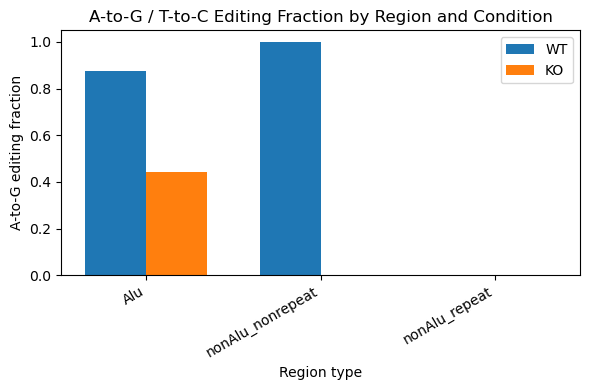

In [ ]:
#Plot1 - A-G fraction bar plot

AG_fraction_pivot = (
    AG_fraction_plot
    .pivot_table(
        index='region_type',
        columns='condition',
        values='AG_fraction',
        fill_value=0
    )
    .reset_index()
)

x = np.arange(len(AG_fraction_pivot['region_type']))
width = 0.35

plt.figure(figsize=(6, 4))

plt.bar(
    x - width/2,
    AG_fraction_pivot['WT'],
    width,
    label='WT'
)

plt.bar(
    x + width/2,
    AG_fraction_pivot['KO'],
    width,
    label='KO'
)

plt.xticks(
    x,
    AG_fraction_pivot['region_type'],
    rotation=30,
    ha='right'
)

plt.ylabel('A-to-G editing fraction')
plt.xlabel('Region type')
plt.title('A-to-G / T-to-C Editing Fraction by Region and Condition')
plt.legend()
plt.tight_layout()
plt.show()

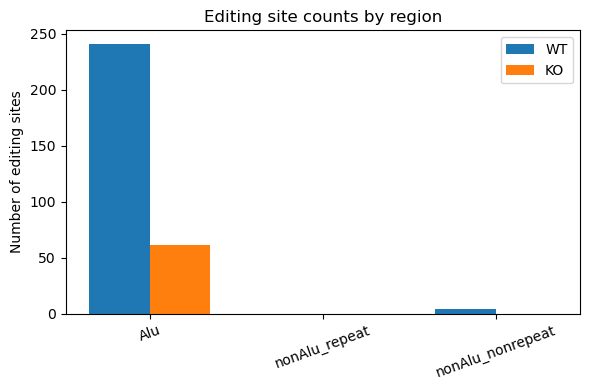

In [ ]:
#Plot2 - Editing site counts bar plot

wt_counts = count_plot[count_plot['condition'] == 'WT']['site_count'].values
ko_counts = count_plot[count_plot['condition'] == 'KO']['site_count'].values

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, wt_counts, width, label='WT')
plt.bar(x + width/2, ko_counts, width, label='KO')

plt.xticks(x, regions, rotation=20)
plt.ylabel('Number of editing sites')
plt.title('Editing site counts by region')
plt.legend()
plt.tight_layout()
plt.show()